In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-03 13:17:39.809083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-25(ii) dataset @2.4GHz

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/2.4GHz/Device-25(ii)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[0.03125  +0.0234375j 0.0078125+0.015625j  0.015625 -0.015625j  ...
 0.0078125+0.015625j  0.015625 +0.0234375j 0.0234375+0.015625j ]
2048
83531
(2048, 83531)
[0.02263969 0.01529919 0.00737484 ... 0.00566509 0.00591057 0.0144904 ]
0
(10000, 2048)
(10000,)
[0.015625 +0.j        0.0234375+0.j        0.0078125+0.0078125j ...
 0.03125  -0.0078125j 0.0234375+0.0234375j 0.015625 +0.j       ]
2048
78338
(2048, 78338)
[0.02961238 0.02458162 0.01655033 ... 0.01719333 0.01524334 0.02118837]
1
(20000, 2048)
(20000,)
[ 0.015625 +0.0078125j  0.03125  +0.0078125j  0.0078125-0.0078125j ...
  0.0234375+0.015625j  -0.015625 +0.j         0.015625 +0.j       ]
2048
89602
(2048, 89602)
[0.02333087 0.01611337 0.00931103 ... 0.01022751 0.01212663 0.01650324]
2
(30000, 2048)
(30000,)
[ 0.015625 -0.015625j   0.0078125+0.0078125j  0.0078125+0.0234375j ...
  0.0234375+0.0078125j -0.0078125+0.0078125j  0.0234375+0.0390625j]
2048
81231
(2048, 81231)
[0.03361239 0.02737371 0.02076487 ... 0.02096687 0.02091695 0.028

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-25(ii) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-04-03 13:25:04.592867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 17s 6ms/step - loss: 7.7670 - accuracy: 0.2472
test loss, test acc: [7.767006874084473, 0.24716250598430634]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 14s 6ms/step
[6 0 7 ... 6 3 6]
6
[[9686    0    0    0    0    0   30  284]
 [   6 9674   13    5    4    2   62  234]
 [   0    1  337    0    1  841    0 8820]
 [   0 9850   24    4   71   10   18   23]
 [  14    2    5    0    0    1 1210 8768]
 [   2  121 9210    4  115   24   27  497]
 [   0 9835    2  106   11    3   31   12]
 [   0   63    1 6308    0    0 3611   17]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     10000
           1       0.33      0.97      0.49     10000
           2       0.04      0.03      0.03     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.03      0.00      0.00     10000
           6       0.01      0.00      0.00     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.25     80000
   macro avg       0.17      0.25  

Test Accuracy:0.2471625


Text(0.5, 1.0, 'Accuracy:0.247')

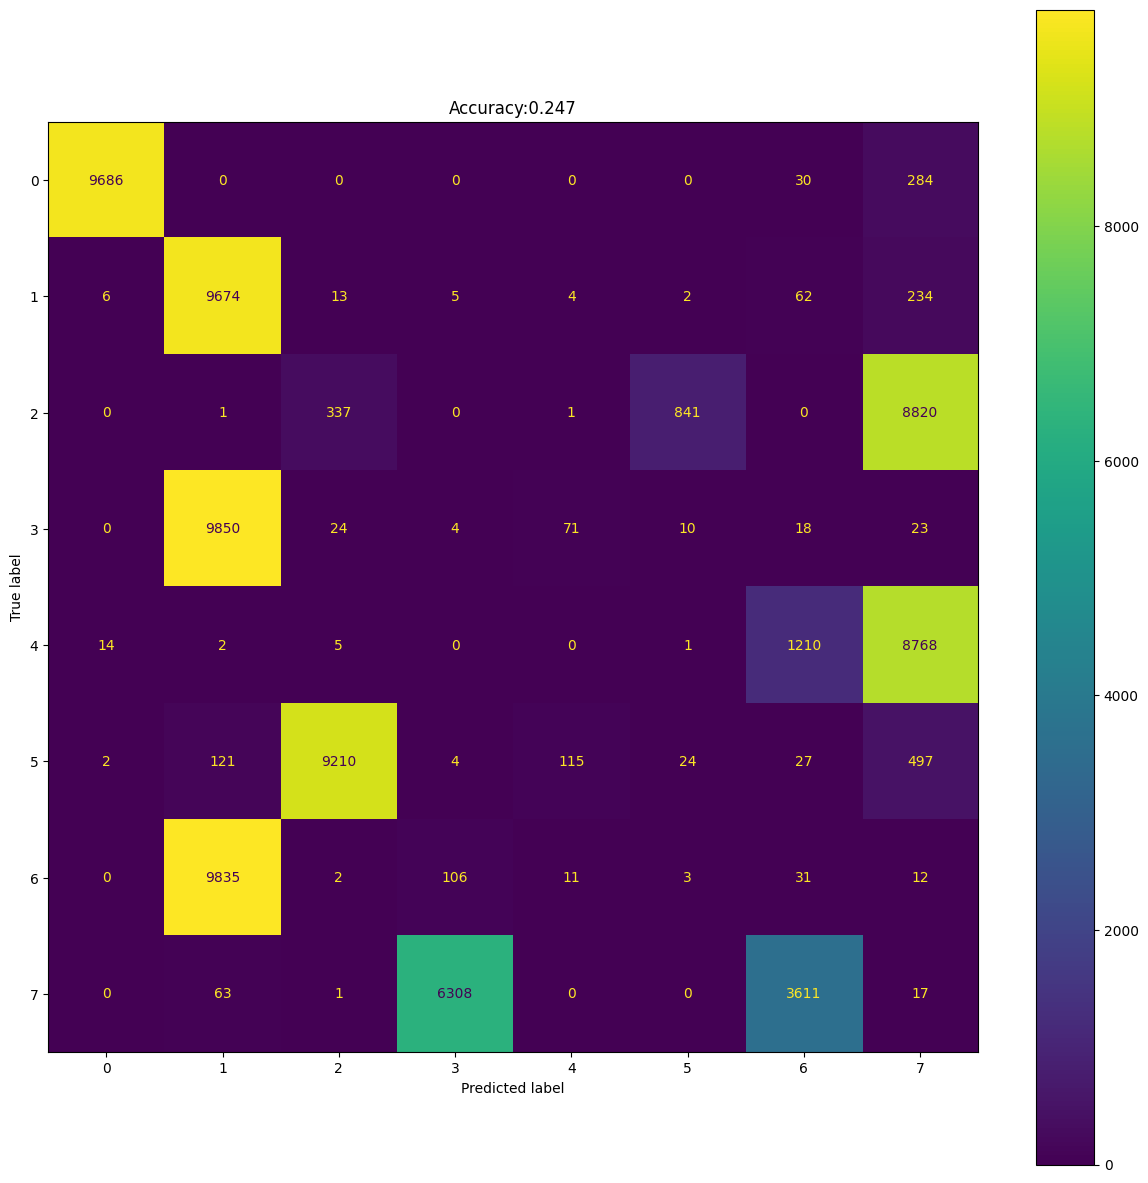

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning @2.4GHz

Nordic Device-25(i) model to Nordic Device-25(ii) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 15s 6ms/step - loss: 1.5276 - accuracy: 0.6053
Epoch 2/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.3873 - accuracy: 0.9074
Epoch 3/30
2500/2500 [==============================] - 14s 5ms/step - loss: 0.3293 - accuracy: 0.9269
Epoch 4/30
2500/2500 [==============================] - 15s 6ms/step - loss: 0.3073 - accuracy: 0.9282
Epoch 5/30
2500/2500 [==============================] - 14s 5ms/step - loss: 0.2954 - accuracy: 0.9291
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2876 - accuracy: 0.9290
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2818 - accuracy: 0.9292
Epoch 8/30
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2773 - accuracy: 0.9299
Epoch 9/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2736 - accuracy: 0.9301
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

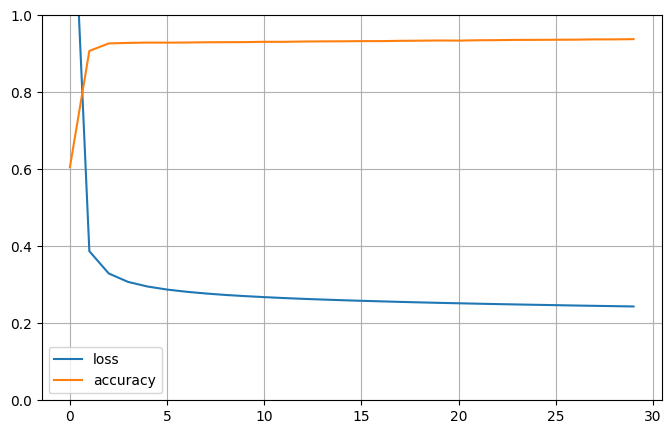

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2438 - accuracy: 0.9389
test loss, test acc: [0.24376970529556274, 0.9388750195503235]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 0 4 ... 7 7 7]
4
[[9902    1    1    0   95    0    0    1]
 [  11 9617    2  211   16   58   79    6]
 [   1    1 9818    1   58  121    0    0]
 [   0  120   10 8293    4   69 1491   13]
 [  16   34  150    1 9759   31    0    9]
 [   8   66   81   68   10 9724   30   13]
 [   0  150    1 1648    7   18 8134   42]
 [   0   38    1    5   41    1   51 9863]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     10000
           1       0.96      0.96      0.96     10000
           2       0.98      0.98      0.98     10000
           3       0.81      0.83      0.82     10000
           4       0.98      0.98      0.98     10000
           5       0.97      0.97      0.97     10000
           6       0.83      0.81      0.82     10000
           7       0.99      0.99      0.99     10000

    accuracy                           0.94     80000
   macro avg       0.94      0.94  

Test Accuracy:0.938875


Text(0.5, 1.0, 'Accuracy:0.939')

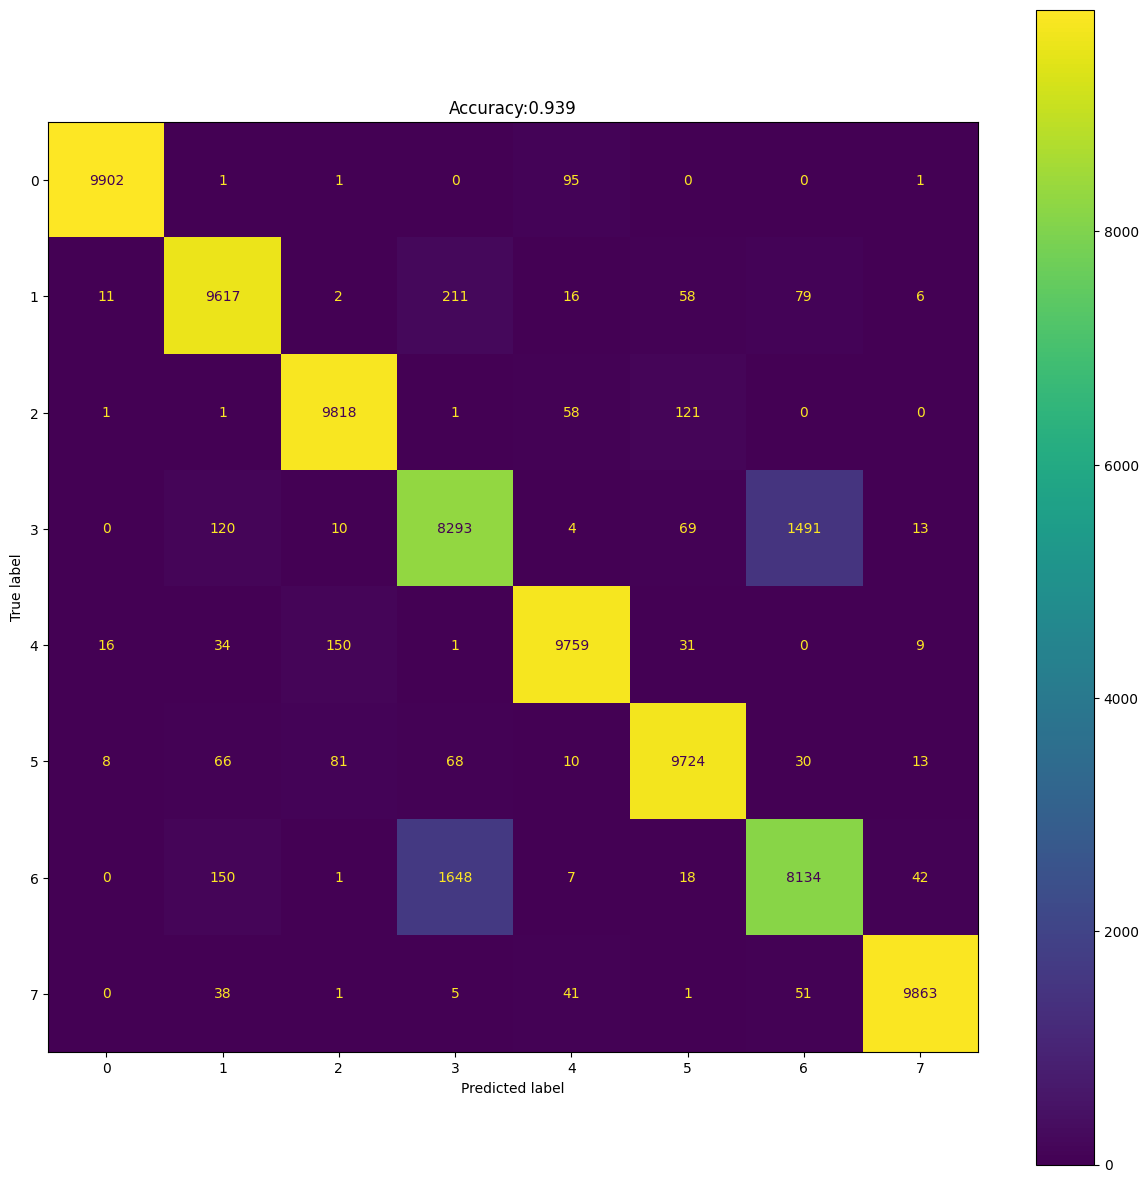

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-25(ii) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 5.1617 - accuracy: 0.3146
test loss, test acc: [5.16165018081665, 0.3145749866962433]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 2 7 ... 6 6 6]
4
[[8168    0 1790    0    8    0    0   34]
 [   4 4966    8    2 4648    8  358    6]
 [   4    2    2    0    7   12    0 9973]
 [   0 7875    0    1   46   17 2057    4]
 [ 918    4   57    0 1964    6    0 7051]
 [  10 1670    0    9  170  300  104 7737]
 [   0  216    0    4   20    0 9760    0]
 [   1   38    3    0   98    0 9855    5]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     10000
           1       0.34      0.50      0.40     10000
           2       0.00      0.00      0.00     10000
           3       0.06      0.00      0.00     10000
           4       0.28      0.20      0.23     10000
           5       0.87      0.03      0.06     10000
           6       0.44      0.98      0.61     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.31     80000
   macro avg       0.36      0.31  

Test Accuracy:0.314575


Text(0.5, 1.0, 'Accuracy:0.315')

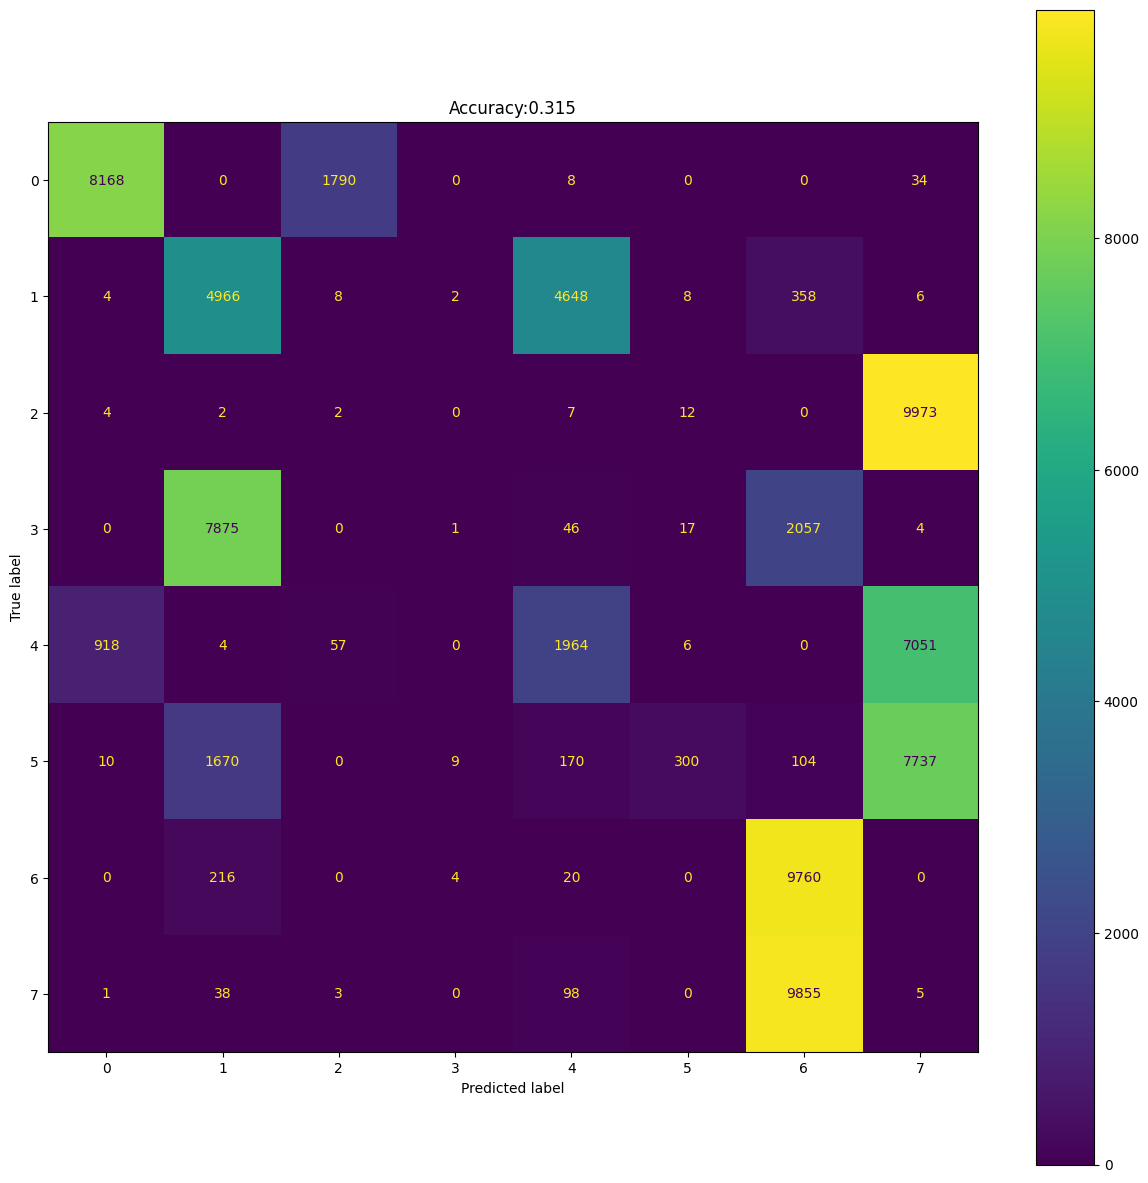

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning @2.4GHz

Nordic Device-25(iii) model to Nordic Device-25(ii) dataset 

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.1753 - accuracy: 0.6315
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4636 - accuracy: 0.8892
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.3776 - accuracy: 0.9270
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.3436 - accuracy: 0.9359
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3236 - accuracy: 0.9402
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3094 - accuracy: 0.9434
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2984 - accuracy: 0.9456
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2894 - accuracy: 0.9478
Epoch 9/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2820 - accuracy: 0.9491
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

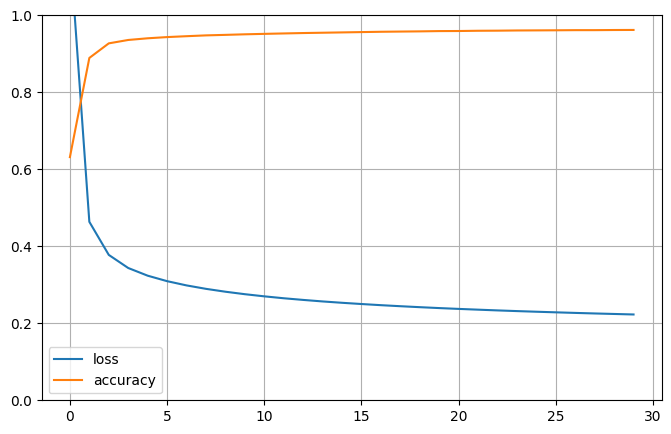

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2222 - accuracy: 0.9621
test loss, test acc: [0.22223681211471558, 0.962149977684021]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 2 ... 7 7 7]
0
[[9922    0   30    0   45    3    0    0]
 [   7 9546    0  267   11  110   26   33]
 [   1    4 9891    0   22   82    0    0]
 [   0  331    0 9180    8   55  404   22]
 [  10   10   68    0 9739  168    0    5]
 [   5   50  118   52   79 9609   32   55]
 [   0   55    0  447    0    9 9406   83]
 [   2   97    0   42   13   27  140 9679]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     10000
           1       0.95      0.95      0.95     10000
           2       0.98      0.99      0.98     10000
           3       0.92      0.92      0.92     10000
           4       0.98      0.97      0.98     10000
           5       0.95      0.96      0.96     10000
           6       0.94      0.94      0.94     10000
           7       0.98      0.97      0.97     10000

    accuracy                           0.96     80000
   macro avg       0.96      0.96  

Test Accuracy:0.96215


Text(0.5, 1.0, 'Accuracy:0.962')

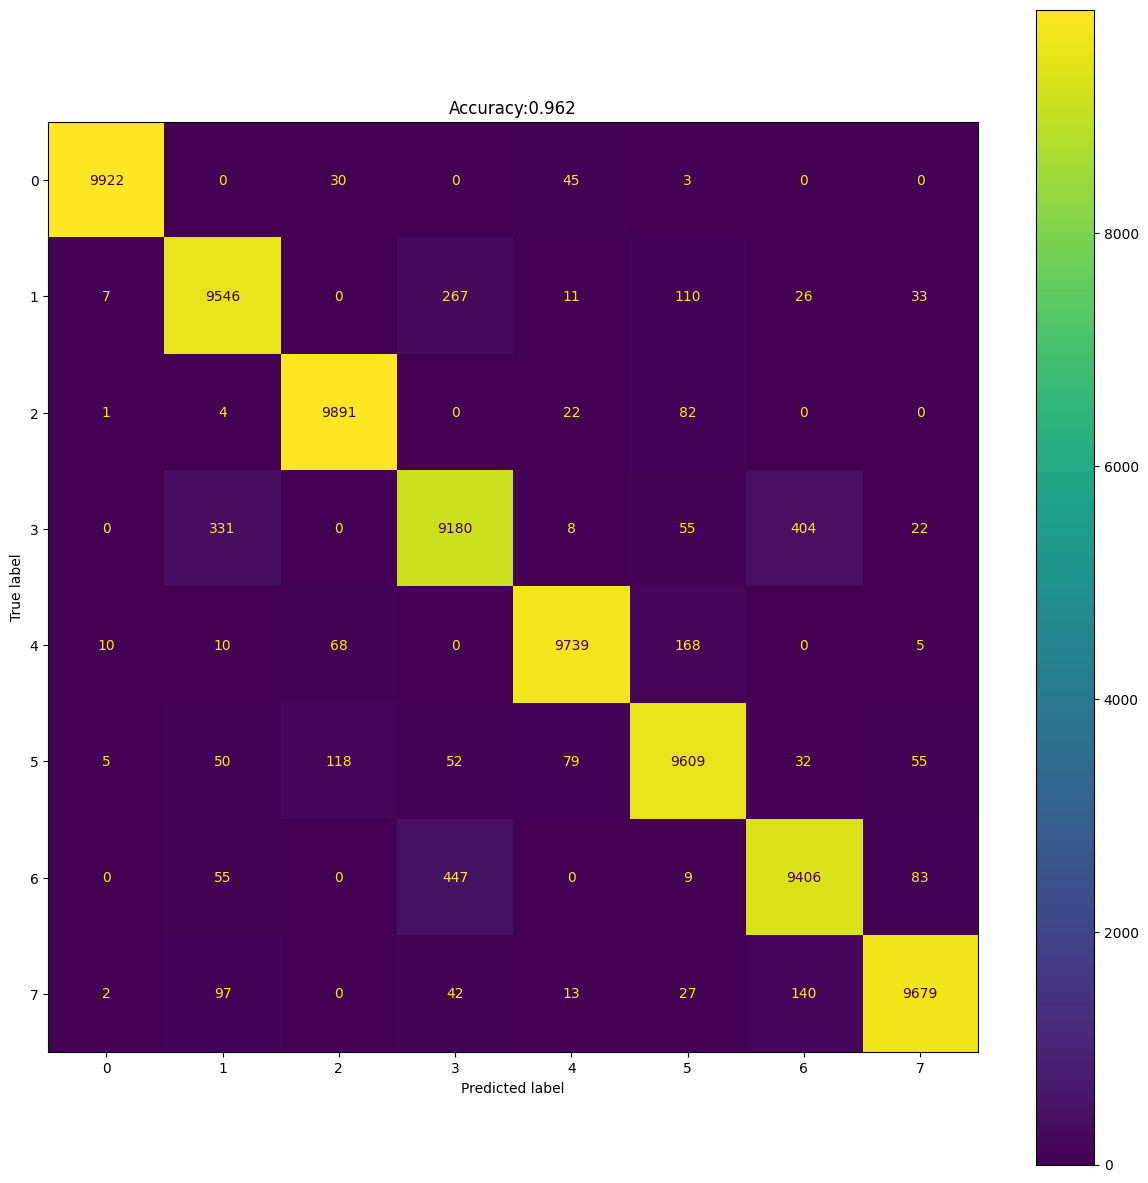

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-30(i) model to Nordic Device-25(ii) dataset 

In [26]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 29.2432 - accuracy: 0.2439
test loss, test acc: [29.243152618408203, 0.24386249482631683]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[2 4 4 ... 3 4 4]
2
[[   0    8    1    3 9988    0    0    0]
 [   0    7    0  136 9845    0   11    1]
 [   0   87    1    3 9909    0    0    0]
 [   2    2   12 9463  459    0   61    1]
 [   0   20    1    1 9978    0    0    0]
 [   4   55    2  100 9816    0   22    1]
 [   2    8   21 4743 5165    0   60    1]
 [   0  115    5 3563 6285    0   32    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.02      0.00      0.00     10000
           2       0.02      0.00      0.00     10000
           3       0.53      0.95      0.68     10000
           4       0.16      1.00      0.28     10000
           5       0.00      0.00      0.00     10000
           6       0.32      0.01      0.01     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.24     80000
   macro avg       0.13      0.24  

Test Accuracy:0.2438625


Text(0.5, 1.0, 'Accuracy:0.244')

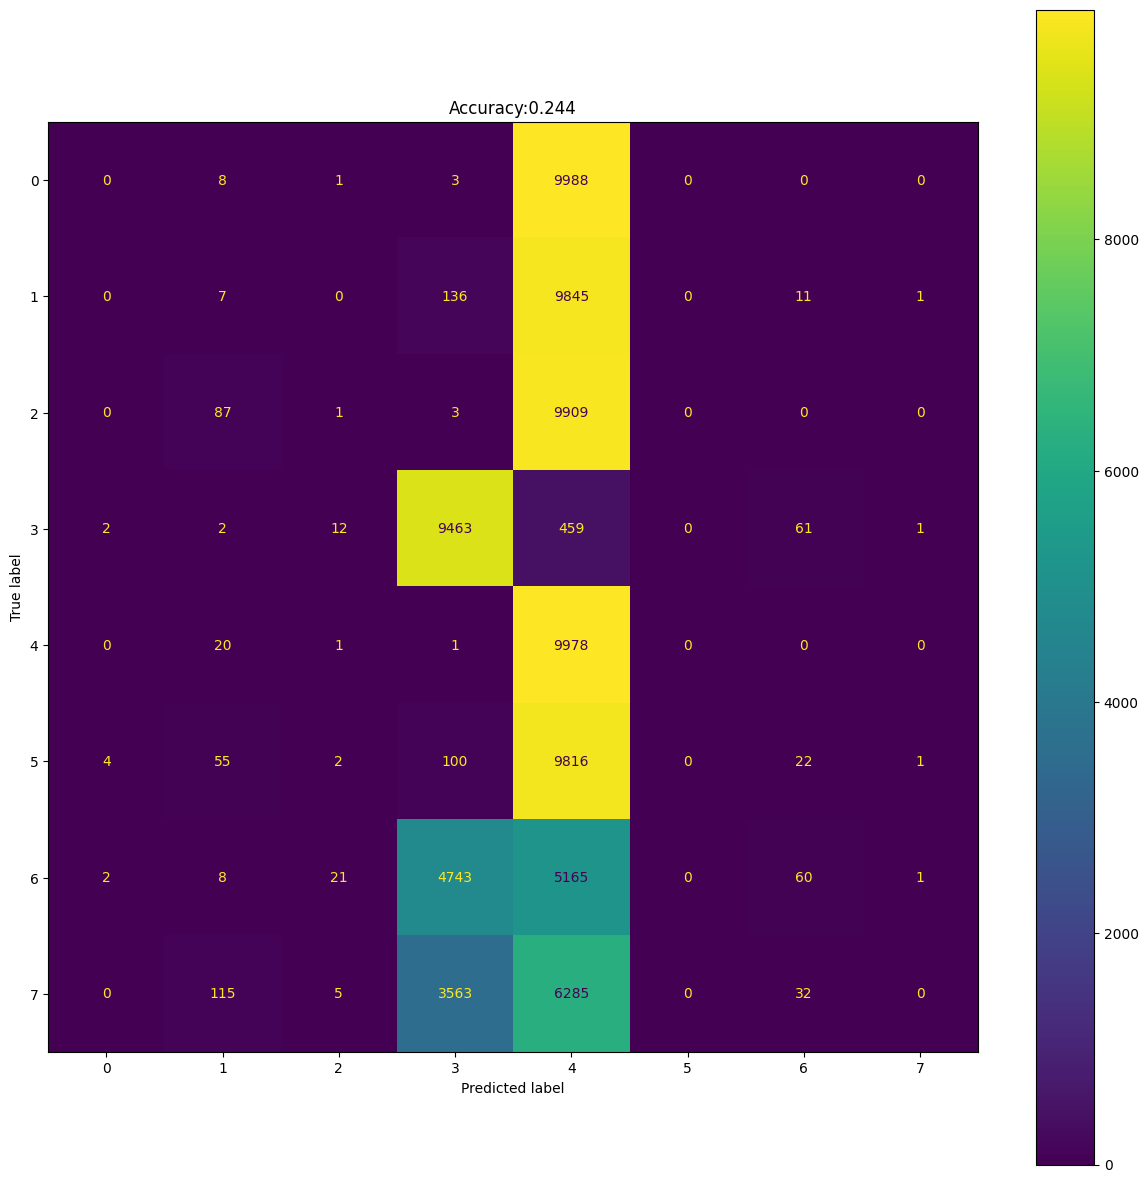

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [30]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [31]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [32]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 3.6217 - accuracy: 0.1873
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3134 - accuracy: 0.5408
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0649 - accuracy: 0.6677
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.9810 - accuracy: 0.7155
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.9350 - accuracy: 0.7274
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.9038 - accuracy: 0.7340
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8805 - accuracy: 0.7395
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8612 - accuracy: 0.7423
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8456 - accuracy: 0.7464
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

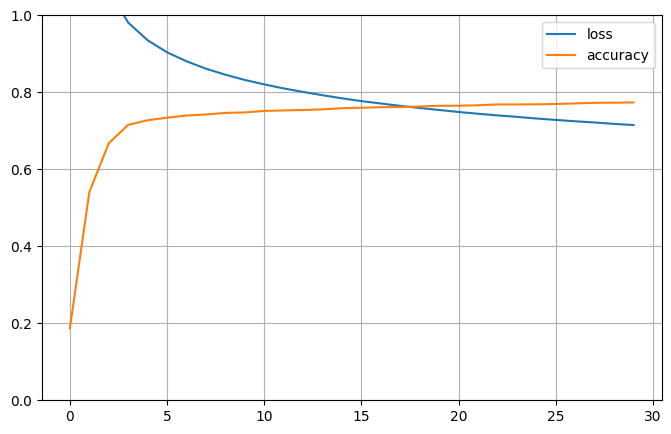

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [34]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.7178 - accuracy: 0.7728
test loss, test acc: [0.7177590131759644, 0.7728250026702881]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[3 4 5 ... 6 7 7]
3
[[6643   15   90    3 3200   44    0    5]
 [   0 8371   14   36    0  322  420  837]
 [  19    7 8167    2 1631  162    1   11]
 [   0   39    5 8487    0   13 1330  126]
 [1063   10  830    2 8069   22    0    4]
 [  21  206  578   54   72 8875   54  140]
 [   0  494    3 1168    0    7 6681 1647]
 [   1 1447  139  326    3   84 1467 6533]]
              precision    recall  f1-score   support

           0       0.86      0.66      0.75     10000
           1       0.79      0.84      0.81     10000
           2       0.83      0.82      0.82     10000
           3       0.84      0.85      0.85     10000
           4       0.62      0.81      0.70     10000
           5       0.93      0.89      0.91     10000
           6       0.67      0.67      0.67     10000
           7       0.70      0.65      0.68     10000

    accuracy                           0.77     80000
   macro avg       0.78      0.77  

Test Accuracy:0.772825


Text(0.5, 1.0, 'Accuracy:0.773')

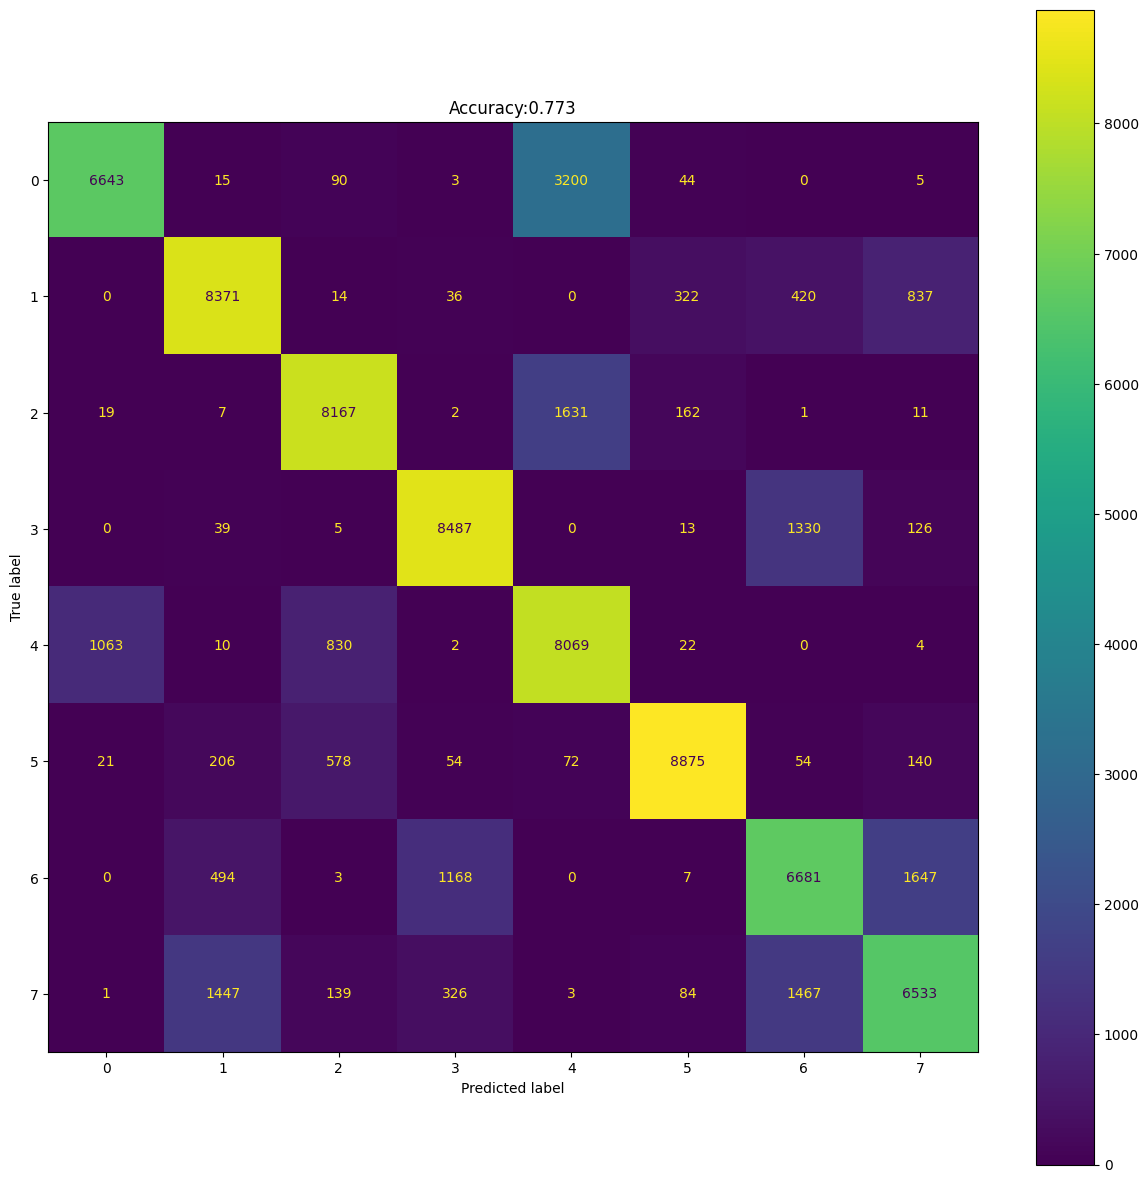

In [36]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(ii) model to Nordic Device-25(ii) dataset 

In [37]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [38]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 18.0689 - accuracy: 0.0447
test loss, test acc: [18.068904876708984, 0.04468749836087227]


In [39]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[4 1 1 ... 0 0 0]
4
[[   0 9721    0  120  159    0    0    0]
 [  51 2437    1 7478   24    8    1    0]
 [   1 9642    0  353    3    1    0    0]
 [8804   33    9 1101   42   10    1    0]
 [   6 3276    0 6712    6    0    0    0]
 [  89 1133    7 8741   11   13    6    0]
 [4127    8   10 5821    3   13   18    0]
 [9361    6    7   73  496   57    0    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.09      0.24      0.13     10000
           2       0.00      0.00      0.00     10000
           3       0.04      0.11      0.05     10000
           4       0.01      0.00      0.00     10000
           5       0.13      0.00      0.00     10000
           6       0.69      0.00      0.00     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.04     80000
   macro avg       0.12      0.04  

Test Accuracy:0.0446875


Text(0.5, 1.0, 'Accuracy:0.045')

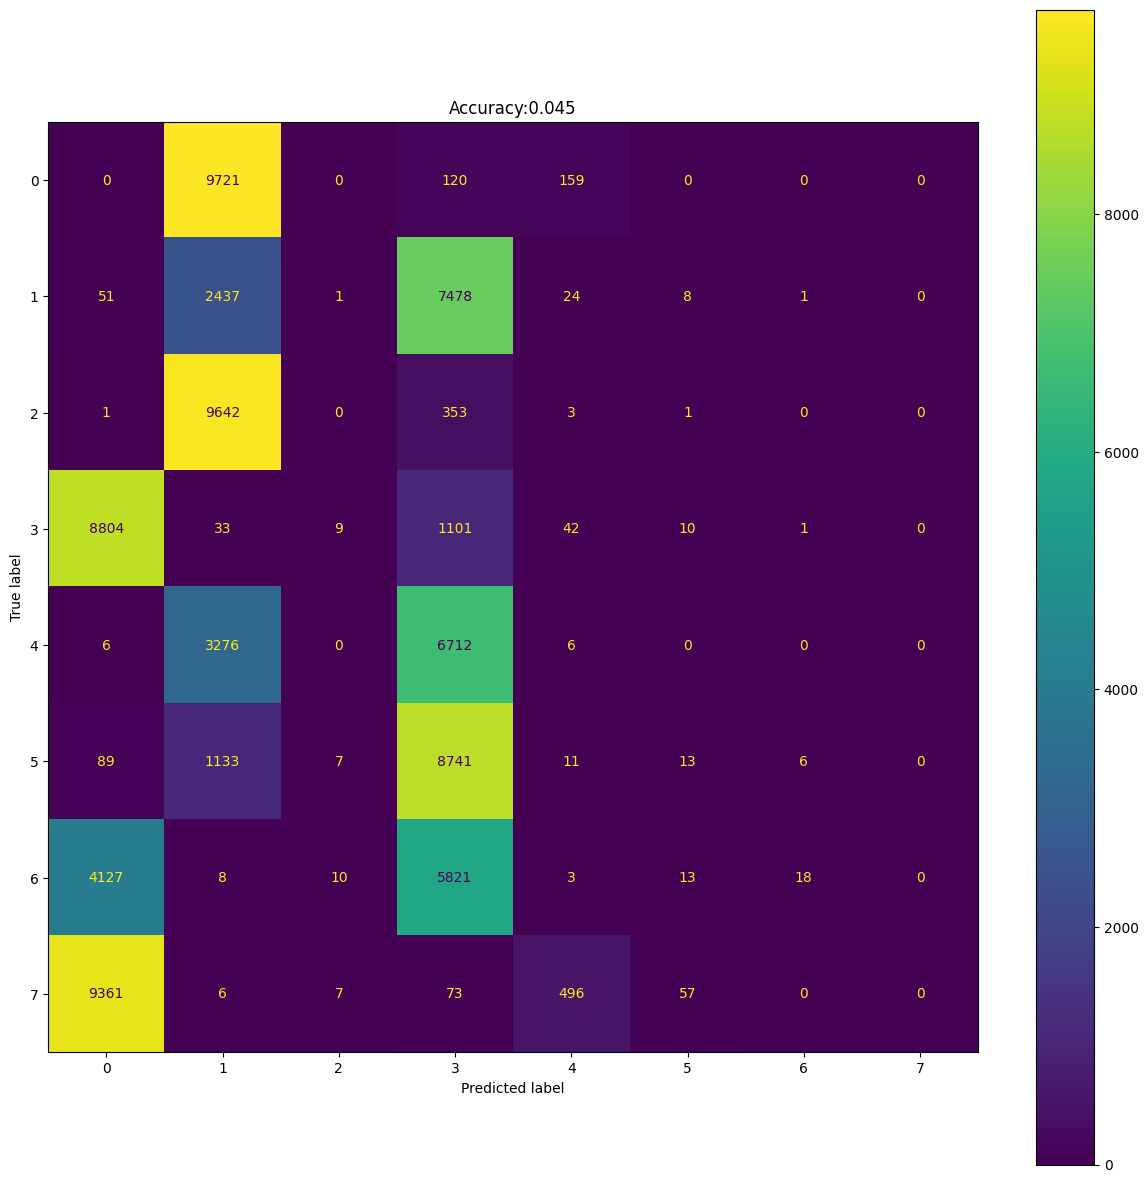

In [40]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [41]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [42]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [43]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.3338 - accuracy: 0.3829
Epoch 2/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.7957 - accuracy: 0.8311
Epoch 3/30
2500/2500 [==============================] - 15s 6ms/step - loss: 0.6380 - accuracy: 0.9116
Epoch 4/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.5666 - accuracy: 0.9192
Epoch 5/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.5225 - accuracy: 0.9223
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4917 - accuracy: 0.9242
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4687 - accuracy: 0.9254
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4512 - accuracy: 0.9269
Epoch 9/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4372 - accuracy: 0.9274
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

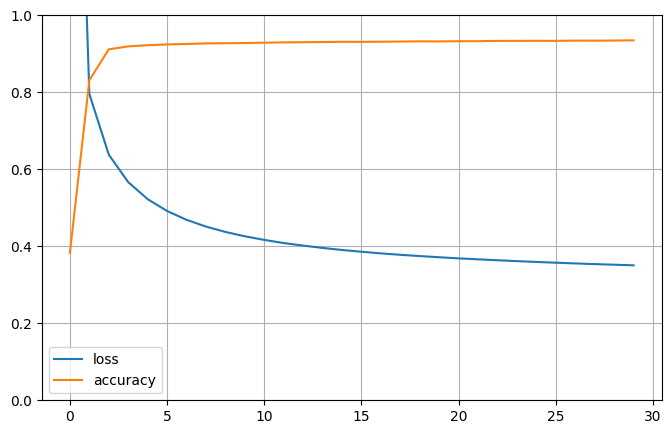

In [44]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [45]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.3499 - accuracy: 0.9355
test loss, test acc: [0.3498668372631073, 0.9355250000953674]


In [46]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 0 2 ... 7 7 7]
7
[[9655   10   34    0  287    4    1    9]
 [   8 9645    3   27   13  186   63   55]
 [  28   12 9552    0   59  339    2    8]
 [  19  127    0 8770   16    5  935  128]
 [ 118    7  144    0 9597  109   13   12]
 [  27  166  453   28   69 9108   58   91]
 [   1   45    0  938    9    0 8884  123]
 [   1   35    0  243   14    8   68 9631]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     10000
           1       0.96      0.96      0.96     10000
           2       0.94      0.96      0.95     10000
           3       0.88      0.88      0.88     10000
           4       0.95      0.96      0.96     10000
           5       0.93      0.91      0.92     10000
           6       0.89      0.89      0.89     10000
           7       0.96      0.96      0.96     10000

    accuracy                           0.94     80000
   macro avg       0.94      0.94  

Test Accuracy:0.935525


Text(0.5, 1.0, 'Accuracy:0.936')

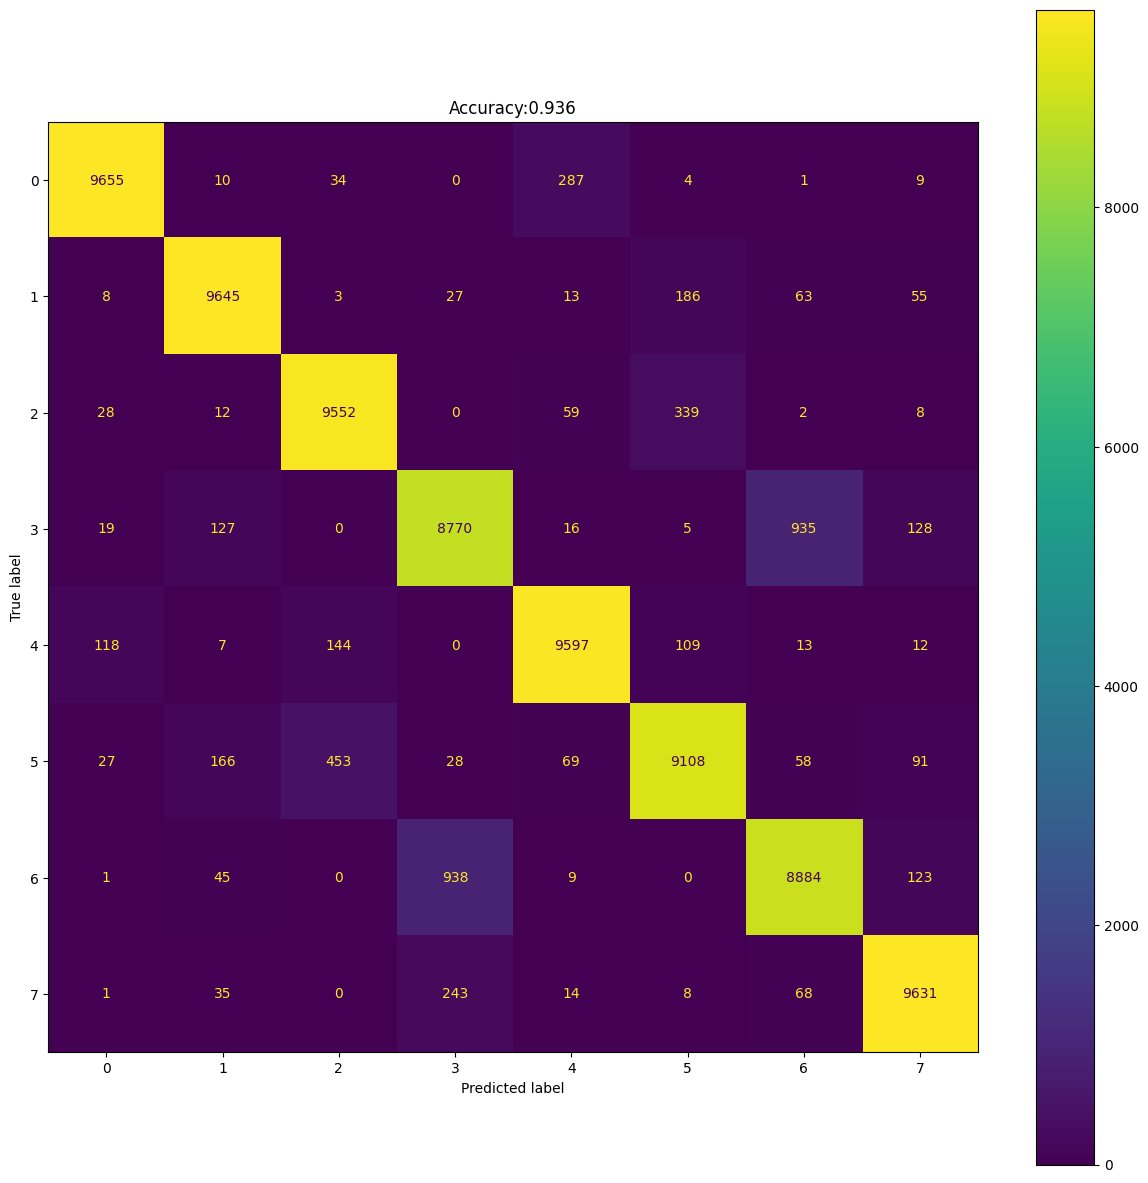

In [47]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-25(ii) dataset 

In [48]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [49]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 13.0999 - accuracy: 0.0988
test loss, test acc: [13.099922180175781, 0.09876249730587006]


In [50]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[2 1 1 ... 2 2 2]
2
[[3452 6545    2    1    0    0    0    0]
 [2106 2633 5197   15   45    2    1    1]
 [   5 9993    2    0    0    0    0    0]
 [  36    8 7769 1808   74  299    4    2]
 [2272 7725    2    1    0    0    0    0]
 [ 355 9536   86    1   18    2    2    0]
 [  16   21 9835   25   79   21    3    0]
 [   4  122 8497  508  427  430   11    1]]
              precision    recall  f1-score   support

           0       0.42      0.35      0.38     10000
           1       0.07      0.26      0.11     10000
           2       0.00      0.00      0.00     10000
           3       0.77      0.18      0.29     10000
           4       0.00      0.00      0.00     10000
           5       0.00      0.00      0.00     10000
           6       0.14      0.00      0.00     10000
           7       0.25      0.00      0.00     10000

    accuracy                           0.10     80000
   macro avg       0.21      0.10  

Test Accuracy:0.0987625


Text(0.5, 1.0, 'Accuracy:0.099')

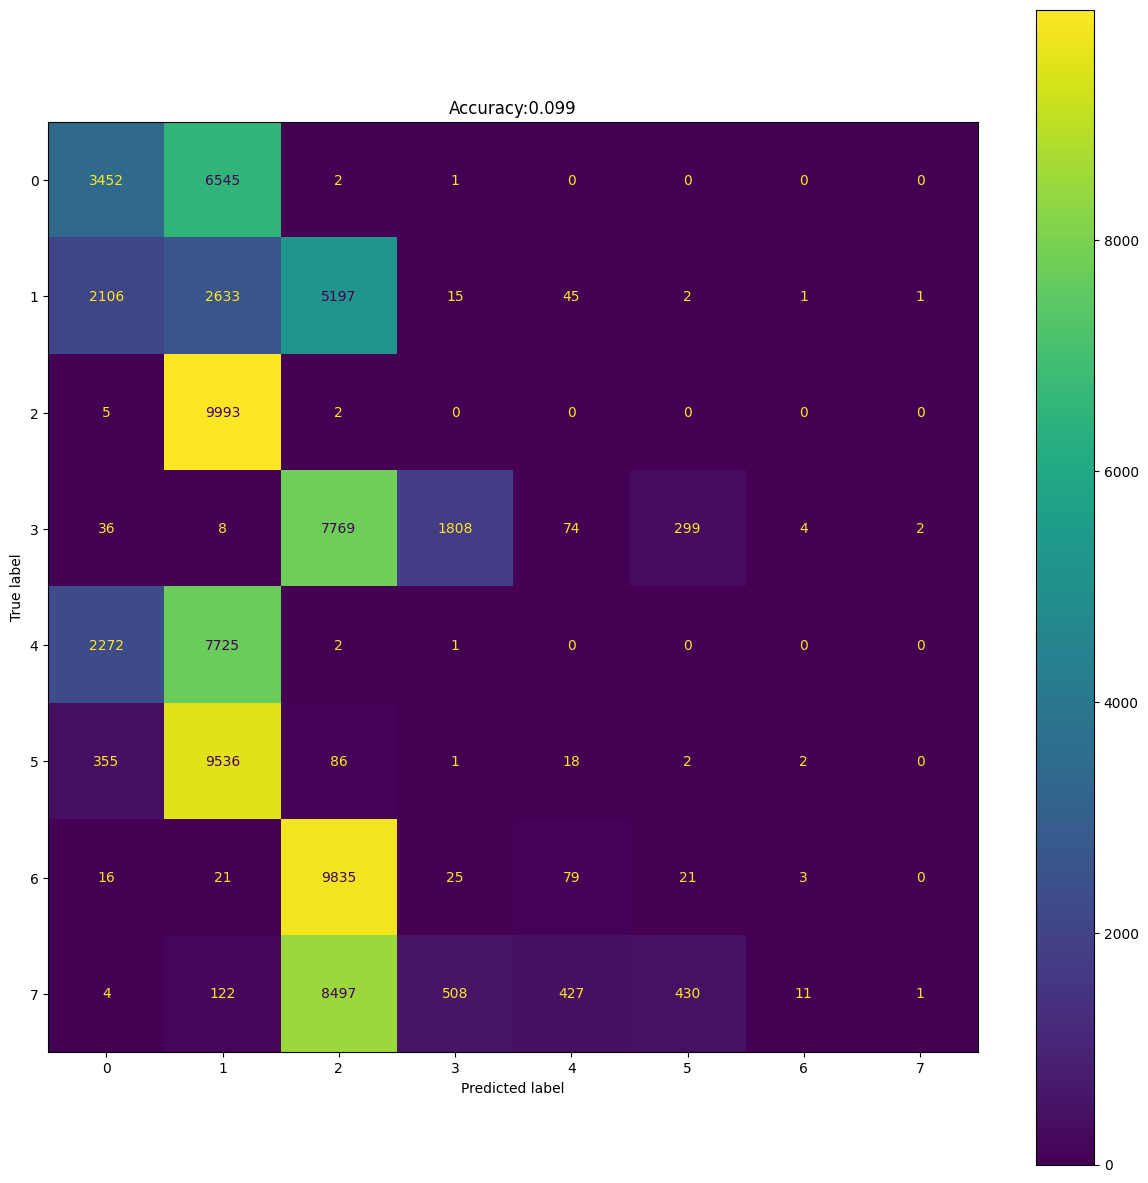

In [51]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [52]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [53]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [54]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.3534 - accuracy: 0.3359
Epoch 2/30
2500/2500 [==============================] - 11s 5ms/step - loss: 1.0336 - accuracy: 0.6441
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.8696 - accuracy: 0.7283
Epoch 4/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.7953 - accuracy: 0.7686
Epoch 5/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.7483 - accuracy: 0.7972
Epoch 6/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.7125 - accuracy: 0.8155
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.6836 - accuracy: 0.8298
Epoch 8/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.6596 - accuracy: 0.8408
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.6387 - accuracy: 0.8493
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

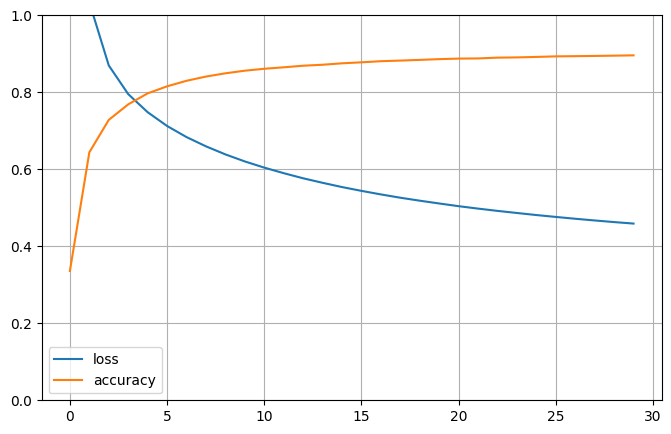

In [55]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [56]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 0.4577 - accuracy: 0.8946
test loss, test acc: [0.45767655968666077, 0.8946124911308289]


In [57]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 0 4 ... 7 7 3]
7
[[9375   10  239    0  173  198    3    2]
 [   5 9560    2   35    1   21  349   27]
 [   2    4 9203    1  735   53    0    2]
 [   0   60    1 9692    0    1   49  197]
 [ 223    7  726    1 8317  721    4    1]
 [ 108  126  466    4 1989 7215   59   33]
 [   2  598    1   79    0    0 9040  280]
 [   1   41   32  269    2   21  467 9167]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     10000
           1       0.92      0.96      0.94     10000
           2       0.86      0.92      0.89     10000
           3       0.96      0.97      0.97     10000
           4       0.74      0.83      0.78     10000
           5       0.88      0.72      0.79     10000
           6       0.91      0.90      0.91     10000
           7       0.94      0.92      0.93     10000

    accuracy                           0.89     80000
   macro avg       0.90      0.89  

Test Accuracy:0.8946125


Text(0.5, 1.0, 'Accuracy:0.895')

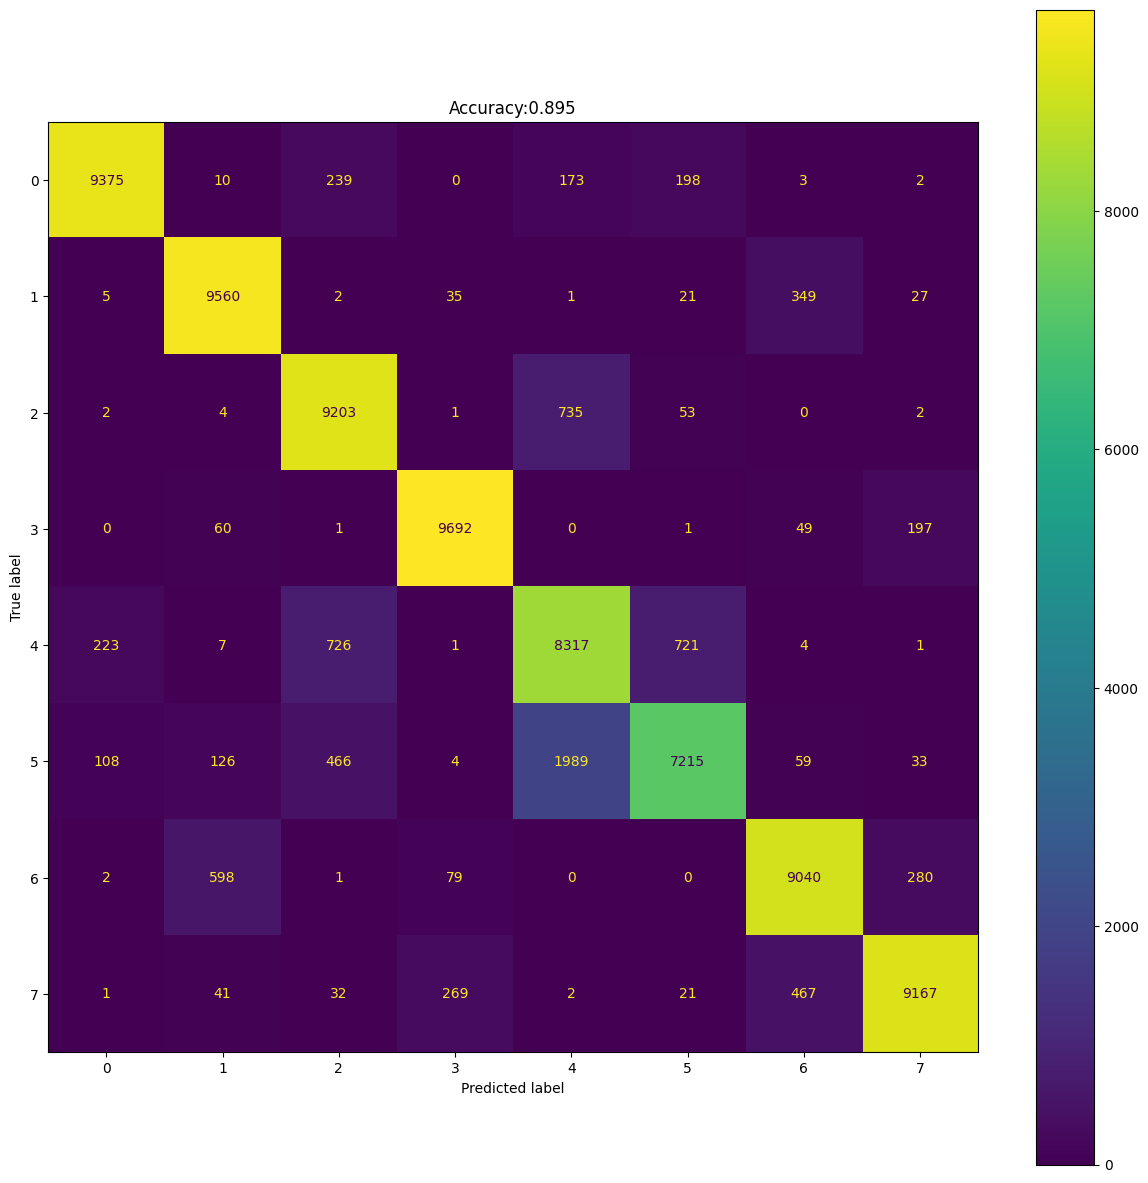

In [58]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')